<a href="https://colab.research.google.com/github/fezilemahlangu/Natural-Language-Processing-Project/blob/main/NLP_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Fezile Mahlangu 

#2089676

#NLP Project 


---

Project: Spam Classification Using Naive Bayes

Aim: Train and optimize a spam classifier using Naive Bayes classification model

Tasks:
- [x] Implement a Naive Bayes Model
- [ ] Investigate the effect of using different features 
- [ ] Evaluate the performance of different models
- [ ] Optimize the model for better performance






---



# Imports

In [92]:
import numpy as np
import pandas as pd
import nltk
import copy
nltk.download('stopwords')
from nltk.tokenize import word_tokenize, wordpunct_tokenize
nltk.download("wordnet")
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import RegexpTokenizer
nltk.download('omw-1.4')

from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix,f1_score
from sklearn.metrics import ConfusionMatrixDisplay
from collections import Counter

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# Loading data

In [28]:
#loading data -> Remember to remove drive path and use normal path

train_df = pd.read_csv("/content/drive/MyDrive/NLP/train.csv")
val_df = pd.read_csv("/content/drive/MyDrive/NLP/val.csv")
test_df = pd.read_csv("/content/drive/MyDrive/NLP/test.csv")
display(train_df)

,text,label
0,"Subject: thank you\r\nami and daren , , , ,\r\...",0
1,"Subject: spot or firm tickets\r\nvance ,\r\nth...",0
2,Subject: software\r\nmicrosoft windows xp prof...,1
3,Subject: noms / actual flow for 2 / 27\r\nwe a...,0
4,Subject: superb so . ftware\r\nyoull discover ...,1
...,...,...
3097,Subject: \r\n( envelope - from 20040929124340 ...,1
3098,Subject: re : intraday eastrans nomination cha...,0
3099,Subject: meter 1601\r\ndaren - meter 1601 has ...,0
3100,Subject: need legal help ?\r\nto unsubscribe f...,1


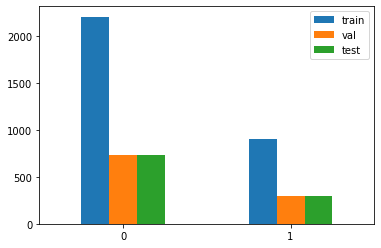

In [29]:

train = [train_df[train_df.label==0].count()[0],train_df[train_df.label==1].count()[0]]
test = [test_df[test_df.label==0].count()[0],test_df[test_df.label==1].count()[0]]
val = [val_df[val_df.label==0].count()[0],val_df[val_df.label==1].count()[0]]

index = ['0', '1']
df = pd.DataFrame({'train': train,
                   'val': val, 'test':test}, index=index)
ax = df.plot.bar(rot=0)



# Preprocessing of data

The text will be tokenized and there will be a list of words for each sentence 

In [4]:
train_df.head()

,text,label
0,"Subject: thank you\r\nami and daren , , , ,\r\...",0
1,"Subject: spot or firm tickets\r\nvance ,\r\nth...",0
2,Subject: software\r\nmicrosoft windows xp prof...,1
3,Subject: noms / actual flow for 2 / 27\r\nwe a...,0
4,Subject: superb so . ftware\r\nyoull discover ...,1


In [30]:
#creating x and y from dataframes 
train_x = train_df.text
train_y = train_df.label

test_x = test_df.text
test_y = test_df.label

val_x = val_df.text
val_y = val_df.label

len(train_x)

# https://www.kaggle.com/code/conniedeng/nlp-eron-dataset


3102

In [31]:
def split_row(row):
  #splits row by "\n"
  return row.split("\n")

In [32]:
def tokenize(row):
  #splits by white space and punct 
  return wordpunct_tokenize(row)

In [33]:
def handle_money(row):
  #puts $5.99 back from ["$","5",".","99"]
  leng = len(row)
  i = 0
  while leng != 0 :
    if row[i]=='$' and row[i+2].isnumeric():
      row = row[:i+1] + row[(i+2):]
      leng-=1

    elif (row[i] == '.' and row[i+2].isnumeric() and row[i-2].isnumeric()):
      row = row[0:i-1] + row[i:i+1] + row[i+2:]
      leng-=2
    i+=1
    leng-=1

  return row
  

In [34]:
# def handle_hyperlinks(row):
#   for i in range(len(row)):
#     if row[i] == "http" or row[i] == "https"


    
#     if row[i] == "com":
#       row[i] = row[i-2] +row[i-1] +  row[i] 
#       print(row)
#       print("deleting")
#       del row[i-1]
#       del row[i-2]
#   return row




In [35]:
def remove_punct(row):
  #romoves punctuation marks 
  # [word for word in row if word.isalpha() or word[0] == "$" or word=="!"] 

  return [word for word in row if word.isalpha()] #check this thos 


In [36]:
stemmer = nltk.stem.porter.PorterStemmer()
def stem_words(row):
  #function that performs stemming 
  # removes word ending crudely -ing 
  return [stemmer.stem(i) for i in row]


In [37]:
lemmatizer = nltk.stem.wordnet.WordNetLemmatizer()
def lemmatize(row):
  #performs lemmatization 
  # make a word a root 
  return [lemmatizer.lemmatize(i) for i in row]

In [38]:
a = ["getting", "google", "meeting","rocks"]

lemmatize(a)

# stem_words(a)

['getting', 'google', 'meeting', 'rock']

In [39]:
tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')

def tokenize_with_money(row):
  #dont split if theres money 
  return tokenizer.tokenize(row)


In [40]:
stop_words = nltk.corpus.stopwords.words('english')

def remove_stop_words(row):
  #removes stop words -> really frequent words  
  return [i for i in row if i not in stop_words]

In [25]:
# print(train_x[2])
# # a = split_row(train_x[0])
# # print(a)
# # 
# a = handle_money(train_x[2])

# print(a)
# print("----------------------------------------------------------------------------------------------------------------------------------------------------------------------")

# a = tokenize_with_money(a)
# print(a)
# print("----------------------------------------------------------------------------------------------------------------------------------------------------------------------")

# a = remove_punct(a)
# print(a)
# print("----------------------------------------------------------------------------------------------------------------------------------------------------------------------")

# a = remove_stop_words(a)
# print(a)
# print("----------------------------------------------------------------------------------------------------------------------------------------------------------------------")


# a = stem_words(a)
# print(a)
# print("----------------------------------------------------------------------------------------------------------------------------------------------------------------------")


# a = lemmatize(a)
# print(a)
# print("----------------------------------------------------------------------------------------------------------------------------------------------------------------------")


In [87]:
def clean_x(data):
  clean = []
  for i in data:
    text = tokenize_with_money(i)

    text = remove_punct(text)

    text = remove_stop_words(text)

    text = stem_words(text)

    text = lemmatize(text)

    clean.append(text)
  return clean 



In [90]:

clean_train_x = clean_x(train_x)
clean_val_x = clean_x(val_x)
clean_test_x = clean_x(test_x)


In [91]:
print("Text before preprocessing: \n")
print(train_x[0])
print("----------------------------------------------------------------------------------------------------------------------------------------------------------------------")
print("Text after preprocessing: \n")
print(clean_train_x[0])
print("----------------------------------------------------------------------------------------------------------------------------------------------------------------------")

Text before preprocessing: 

Subject: thank you
ami and daren , , , ,
just wanted again to say thanks ! ! ! , for the great time at st . pete ' s beach ,
fla .
the company , food , fishing and yes , of coarse
the drink or many drinks were great ! ! ! daren , can relate to the drinks .
i enjoyed meeting everyone there .
we appreciate your business and look forward to continue our business relation
with enron in the future .
sincerely ,
tim
----------------------------------------------------------------------------------------------------------------------------------------------------------------------
Text after preprocessing: 

['subject', 'thank', 'ami', 'daren', 'want', 'say', 'thank', 'great', 'time', 'st', 'pete', 'beach', 'fla', 'compani', 'food', 'fish', 'ye', 'coars', 'drink', 'mani', 'drink', 'great', 'daren', 'relat', 'drink', 'enjoy', 'meet', 'everyon', 'appreci', 'busi', 'look', 'forward', 'continu', 'busi', 'relat', 'enron', 'futur', 'sincer', 'tim']
---------------------

In [ ]:
#removing hyperlinks 

In [19]:
# print(train_x[10])

# Training a standard Naive Bayes model 

In [54]:
# #scale data ?

# from sklearn.preprocessing import StandardScaler

# sc = StandardScaler()

# x_train is after count_vector.fit 
# x_train = sc.fit_transform(x_train)
# x_test = sc.transform(x_test)

#LAPLACE SMOOTHING 

In [47]:
#transforming to numeric form for MultinomialNB

count_vector = CountVectorizer()

clean_train_x_join = [" ".join(i) for i in clean_train_x] #turn to string for count_vector 


trans_x = count_vector.fit_transform(clean_train_x_join)

trans_x_dense = np.array(trans_x.todense())

Model1 = MultinomialNB().fit(trans_x_dense,train_y) #multi ???

In [22]:
# trans_x[0][0]
# https://www.kaggle.com/code/syamalakumar/spam-ham-nlp-basic-project

# https://www.kaggle.com/code/dilip990/spam-ham-detection-using-naive-bayes-classifier

# https://www.kaggle.com/code/conniedeng/nlp-eron-dataset


#https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html

# https://www.kdnuggets.com/2020/06/naive-bayes-algorithm-everything.html



## Naive Bayes model using 10 most frequent words as features 

In [101]:
all_clean_x = []
for arr in clean_train_x:
  for i in range(1,len(arr)): #doesnt include "subject" 
      # print(arr[i])
      all_clean_x.append(arr[i])

In [104]:
print(all_clean_x[0:50]) #doesnt inlcude subject

['thank', 'ami', 'daren', 'want', 'say', 'thank', 'great', 'time', 'st', 'pete', 'beach', 'fla', 'compani', 'food', 'fish', 'ye', 'coars', 'drink', 'mani', 'drink', 'great', 'daren', 'relat', 'drink', 'enjoy', 'meet', 'everyon', 'appreci', 'busi', 'look', 'forward', 'continu', 'busi', 'relat', 'enron', 'futur', 'sincer', 'tim', 'spot', 'firm', 'ticket', 'vanc', 'follow', 'nomin', 'deal', 'ticket', 'sitara', 'septemb', 'activ', 'plea']


In [52]:
#get top 10 features using counter 
Counter = Counter(all_clean_x)

top10 = Counter.most_common(10)

print(top10)
  
# print(most_occur)

[('ect', 8343), ('hou', 4376), ('enron', 3908), ('com', 2452), ('deal', 2200), ('plea', 1892), ('ga', 1794), ('subject', 1674), ('meter', 1569), ('hpl', 1404)]


In [64]:
top_10_dictionary=[]
for i in top10:
  top_10_dictionary.append(i[0])
print(top_10_dictionary)


['ect', 'hou', 'enron', 'com', 'deal', 'plea', 'ga', 'subject', 'meter', 'hpl']


In [94]:
top10_train_x = []
# top10_train_x[0]
for arr in clean_train_x:
  new_arr = []
  for word in arr:
    if word in top_10_dictionary:
      new_arr.append(word)
  top10_train_x.append(new_arr)




In [109]:
try:
  len(clean_train_x) == len(top10_train_x)
except:
  print("lengths do not match ")

In [106]:
print("First element clean:")
print(clean_train_x[0])
print("First element with top 10 features:")
print(top10_train_x[0])
print("--------------------------------------------------------------------")
print("Second element clean:")
print(clean_train_x[1])
print("Second element with top 10 features:")
print(top10_train_x[1])
print("--------------------------------------------------------------------")
print("Third element clean:")
print(clean_train_x[2])
print("Third element with top 10 features:")
print(top10_train_x[2])

First element clean:
['subject', 'thank', 'ami', 'daren', 'want', 'say', 'thank', 'great', 'time', 'st', 'pete', 'beach', 'fla', 'compani', 'food', 'fish', 'ye', 'coars', 'drink', 'mani', 'drink', 'great', 'daren', 'relat', 'drink', 'enjoy', 'meet', 'everyon', 'appreci', 'busi', 'look', 'forward', 'continu', 'busi', 'relat', 'enron', 'futur', 'sincer', 'tim']
First element with top 10 features:
['subject', 'enron']
--------------------------------------------------------------------
Second element clean:
['subject', 'spot', 'firm', 'ticket', 'vanc', 'follow', 'nomin', 'deal', 'ticket', 'sitara', 'septemb', 'activ', 'plea', 'advis', 'whether', 'deal', 'spot', 'firm', 'daren', 'want', 'everyth', 'sitara', 'pm', 'monday', 'august', 'thank', 'bob', 'sourc', 'meter', 'sept', 'nom', 'ccgm', 'lp', 'cross', 'tex', 'cummin', 'walker', 'unk', 'dalla', 'product', 'duke', 'energi', 'trade', 'eex', 'oper', 'eog', 'resourc', 'hesco', 'gather', 'hesco', 'gather', 'ph', 'explor', 'pioneer', 'explor', 

In [115]:
#Naive base model 
count_vector = CountVectorizer()

top10_train_x_join = [" ".join(i) for i in top10_train_x] #turn to string for count_vector 

trans_x = count_vector.fit_transform(top10_train_x_join)

trans_x_dense = np.array(trans_x.todense())

Model2 = MultinomialNB().fit(trans_x_dense,train_y) #multi ???

## Naive Bayes model using 100 most frequent words as features 

In [116]:
Counter = Counter(all_clean_x)

top100 = Counter.most_common(100)

print(top100)

top_100_dictionary=[]
for i in top100:
  top_100_dictionary.append(i[0])
print(top_100_dictionary)

[('ect', 8343), ('hou', 4376), ('enron', 3908), ('com', 2452), ('deal', 2200), ('plea', 1892), ('ga', 1794), ('subject', 1674), ('meter', 1569), ('hpl', 1404), ('cc', 1392), ('thank', 1348), ('pm', 1331), ('need', 1249), ('e', 1203), ('daren', 1120), ('forward', 1091), ('price', 1089), ('volum', 1040), ('corp', 1030), ('know', 976), ('day', 950), ('new', 898), ('get', 892), ('compani', 873), ('j', 813), ('may', 806), ('mmbtu', 802), ('product', 800), ('chang', 788), ('see', 771), ('u', 766), ('l', 763), ('http', 756), ('contract', 751), ('inform', 737), ('attach', 713), ('let', 692), ('nom', 676), ('time', 673), ('farmer', 665), ('xl', 658), ('month', 653), ('would', 641), ('sale', 639), ('nomin', 632), ('messag', 618), ('mail', 607), ('one', 603), ('th', 594), ('call', 578), ('flow', 572), ('juli', 571), ('follow', 563), ('use', 561), ('robert', 556), ('question', 551), ('email', 517), ('ticket', 516), ('file', 515), ('net', 515), ('p', 512), ('report', 503), ('want', 500), ('look', 4

In [118]:
top100_train_x = []
# top10_train_x[0]
for arr in clean_train_x:
  new_arr = []
  for word in arr:
    if word in top_100_dictionary:
      new_arr.append(word)
  top100_train_x.append(new_arr)

In [119]:
try:
  len(clean_train_x) == len(top100_train_x)
except:
  print("lengths do not match ")

In [120]:
print("First element clean:")
print(clean_train_x[0])
print("First element with top 10 features:")
print(top100_train_x[0])
print("--------------------------------------------------------------------")
print("Second element clean:")
print(clean_train_x[1])
print("Second element with top 10 features:")
print(top100_train_x[1])
print("--------------------------------------------------------------------")
print("Third element clean:")
print(clean_train_x[2])
print("Third element with top 10 features:")
print(top100_train_x[2])

First element clean:
['subject', 'thank', 'ami', 'daren', 'want', 'say', 'thank', 'great', 'time', 'st', 'pete', 'beach', 'fla', 'compani', 'food', 'fish', 'ye', 'coars', 'drink', 'mani', 'drink', 'great', 'daren', 'relat', 'drink', 'enjoy', 'meet', 'everyon', 'appreci', 'busi', 'look', 'forward', 'continu', 'busi', 'relat', 'enron', 'futur', 'sincer', 'tim']
First element with top 10 features:
['subject', 'thank', 'daren', 'want', 'thank', 'time', 'compani', 'daren', 'busi', 'look', 'forward', 'busi', 'enron']
--------------------------------------------------------------------
Second element clean:
['subject', 'spot', 'firm', 'ticket', 'vanc', 'follow', 'nomin', 'deal', 'ticket', 'sitara', 'septemb', 'activ', 'plea', 'advis', 'whether', 'deal', 'spot', 'firm', 'daren', 'want', 'everyth', 'sitara', 'pm', 'monday', 'august', 'thank', 'bob', 'sourc', 'meter', 'sept', 'nom', 'ccgm', 'lp', 'cross', 'tex', 'cummin', 'walker', 'unk', 'dalla', 'product', 'duke', 'energi', 'trade', 'eex', 'op

In [121]:
#Naive base model 
count_vector = CountVectorizer()

top100_train_x_join = [" ".join(i) for i in top100_train_x] #turn to string for count_vector 

trans_x = count_vector.fit_transform(top100_train_x_join)

trans_x_dense = np.array(trans_x.todense())

Model3 = MultinomialNB().fit(trans_x_dense,train_y) #multi ???

## Naive Bayes model removing 100 most frequent words from features 

## Naive Bayes model using subject line as the feature set

# Evaluation using validation set

## Calculating the evaluation metrics

## Comparing all 5 models 

## Recommended model and reasons

# Evaluation using test set

## Is recommendation still valid?

# Implementation of 1 more variation to improve performance 

## Evaluation of improved model